In [1]:
#Supress Warnings
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from tqdm.notebook import tqdm
from datetime import datetime, timedelta
import xarray as xr
from herbie import Herbie
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from geographiclib.geodesic import Geodesic
import metpy.constants as const
import metpy.calc as mpcalc
from metpy.units import units
import scipy.interpolate as interps
from scipy.interpolate import RegularGridInterpolator
from glob import glob
import os

def hour_rounder(t):
    """
    Round a datetime to the nearest hour.

    Rounds down to the hour when minutes < 30, and rounds up to the next
    hour when minutes >= 30. Seconds and microseconds are discarded.

    Parameters
    ----------
    t : datetime.datetime
        Input time.

    Returns
    -------
    datetime.datetime
        Time rounded to the nearest hour.
    """
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               + timedelta(hours=t.minute//30))


def get_dx_dy(meso_lon, meso_lat, ob_lon, ob_lat):
    """
    Compute local Cartesian offsets (dx, dy) between two lat/lon points.

    Uses GeographicLib's geodesic inverse solution on WGS84 to compute
    great-circle distance and azimuth, then converts to x/y components
    in meters relative to the start point (meso_lat, meso_lon).

    Parameters
    ----------
    meso_lon, meso_lat : float
        Starting longitude and latitude (degrees).
    ob_lon, ob_lat : float
        Destination longitude and latitude (degrees).

    Returns
    -------
    dx : float
        East–west offset in meters (positive eastward).
    dy : float
        North–south offset in meters (positive northward).
    """
    res = Geodesic.WGS84.Inverse(meso_lat, meso_lon, ob_lat, ob_lon)
    dx = res['s12'] * np.sin(np.radians(res['azi1']))
    dy = res['s12'] * np.cos(np.radians(res['azi1']))
    return dx, dy


def subset_data_km(clat, clon, lat2d, lon2d, data2d, dlat_km, dlon_km):
    """Subset a curvilinear grid within +/- dlat_km north/south and +/- dlon_km east/west.

    Performs a fast equirectangular approximation around (clat, clon) to compute
    local km offsets, then returns the smallest rectangular subgrid that contains
    all points within the requested km extents.

    Parameters
    ----------
    clat, clon : float
        Center latitude/longitude in degrees.
    lat2d, lon2d : 2D array-like
        Latitude/longitude fields matching `data2d` shape.
    data2d : 2D array-like
        Field to subset (same shape as `lat2d`/`lon2d`).
    dlat_km, dlon_km : float
        Half-width (north/south) and half-length (east/west) in kilometers.

    Returns
    -------
    lat_sub : 2D ndarray
        Subset latitude array.
    lon_sub : 2D ndarray
        Subset longitude array (normalized to the center’s wrapping).
    data_sub : 2D ndarray
        Subset of `data2d` over the same indices.

    Raises
    ------
    ValueError
        If no grid points fall within the requested km box.
    """
    lat2d = np.asarray(lat2d); lon2d = np.asarray(lon2d); data2d = np.asarray(data2d)

    # normalize longitudes to the convention of clon
    def wrap_like(lon, ref):
        if np.nanmax(lon) > 180:
            lon = lon % 360.0
            ref = ref % 360.0
        else:
            lon = ((lon + 180) % 360) - 180
            ref = ((ref + 180) % 360) - 180
        return lon, ref
    lon2d, clon = wrap_like(lon2d, clon)

    # simple local equirectangular approximation (fine over a few hundred km)
    deg2km = 111.32
    coslat = np.cos(np.deg2rad(clat))
    dx_km = ( ((lon2d - clon + 180) % 360) - 180 ) * coslat * deg2km
    dy_km = (lat2d - clat) * deg2km

    m = (np.abs(dx_km) <= dlon_km) & (np.abs(dy_km) <= dlat_km)
    if not np.any(m):
        raise ValueError("No grid points fell inside the requested km box.")

    i_idx, j_idx = np.where(m)
    i0, i1 = i_idx.min(), i_idx.max()
    j0, j1 = j_idx.min(), j_idx.max()
    return (lat2d[i0:i1+1, j0:j1+1],
            lon2d[i0:i1+1, j0:j1+1],
            data2d[i0:i1+1, j0:j1+1])


def interp_columns_to_uniform_z(p_z, z3d, th3d, qv3d, u3d, v3d, zmax=20000.0, dz=100.0):
    """
    Interpolate each (y, x) atmospheric column to a uniform height grid.

    Inserts a z=0 crossing per column (via linear interpolation), derives
    surface values (psfc, th0, qv0, u0, v0), then interpolates each field
    onto a uniform height vector using:
      * linear interpolation for theta, qv, u, v
      * log-linear interpolation for pressure

    Parameters
    ----------
    p_z : (nz,) array-like
        Native pressure at model levels [Pa] (same vertical levels as `z3d`).
    z3d : (nz, ny, nx) array-like
        Geopotential height [m], strictly increasing in z per column.
    th3d, qv3d, u3d, v3d : (nz, ny, nx) array-like
        Potential temperature [K], water vapor mixing ratio [kg/kg],
        and wind components [m/s].
    zmax : float, optional
        Top of the target uniform grid in meters, by default 20000.0.
    dz : float, optional
        Vertical spacing for the uniform grid in meters, by default 100.0.

    Returns
    -------
    z_target : (nz_t,) ndarray
        Uniform height grid [m] from 0 to `zmax`.
    p_uni : (nz_t, ny, nx) ndarray
        Pressure [Pa] on `z_target` (log-linear).
    th_uni : (nz_t, ny, nx) ndarray
        Potential temperature [K] on `z_target` (linear).
    qv_uni : (nz_t, ny, nx) ndarray
        Water vapor mixing ratio [kg/kg] on `z_target` (linear).
    u_uni, v_uni : (nz_t, ny, nx) ndarray
        Wind components [m/s] on `z_target` (linear).
    psfc : (ny, nx) ndarray
        Pressure at z=0 [Pa] for each column.
    th0 : (ny, nx) ndarray
        Theta at z=0 [K] for each column.
    qv0 : (ny, nx) ndarray
        Qv at z=0 [kg/kg] for each column.

    Notes
    -----
    * Minimal guards are included for duplicate z points around the z=0 insert.
    * No extrapolation beyond native column bounds; the uniform grid is clipped
      to the available column span per column.
    """
    nz, ny, nx = z3d.shape
    z_target = np.arange(0.0, zmax + 1e-9, dz)

    # ---- z=0 crossing per column (same logic you already have) ----
    z0 = z3d[:-1]                 # (nz-1, ny, nx)
    z1 = z3d[1:]                  # (nz-1, ny, nx)
    cross = (z0 <= 0.0) & (z1 >= 0.0)
    k_cross = cross.argmax(axis=0)            # (ny, nx)
    has_cross = cross.any(axis=0)
    caseA = z3d[0]  >= 0.0                    # entire column above 0
    caseB = z3d[-1] <= 0.0                    # entire column below 0
    k = np.where(has_cross, k_cross, np.where(caseA, 0, nz-2))  # bracketing k

    jj, ii = np.meshgrid(np.arange(ny), np.arange(nx), indexing="ij")
    zk  = z3d[k,   jj, ii]
    zk1 = z3d[k+1, jj, ii]
    denom = (zk1 - zk)
    w0 = np.where(np.abs(denom) > 0, (-zk) / denom, 0.0)

    def interp0(f3d):
        fk  = f3d[k,   jj, ii]
        fk1 = f3d[k+1, jj, ii]
        return fk + w0 * (fk1 - fk)

    # z=0 values
    psfc = interp0(p_z[:, None, None].repeat(ny, axis=1).repeat(nx, axis=2))
    th0  = interp0(th3d)
    qv0  = interp0(qv3d)
    u0  = interp0(u3d)
    v0  = interp0(v3d)

    # ---- Build per-column z and fields including z=0, then interpolate to uniform grid ----
    # For each column, create column arrays: z_col (length nz+1), th_col, qv_col, p_col(=p_z)
    # Insert z=0 between k and k+1 with the interpolated values.
    # We’ll interpolate to z_target using np.interp (linear), except pressure in log-space.

    # Flatten columns for vectorized loops
    ncol = ny * nx
    zcol = z3d.reshape(nz, ncol)            # (nz, ncol)
    thcol = th3d.reshape(nz, ncol)
    qvcol = qv3d.reshape(nz, ncol)
    ucol  = u3d.reshape(nz, ncol)
    vcol  = v3d.reshape(nz, ncol)
    k_flat = k.reshape(ncol)
    psfc_flat = psfc.reshape(ncol)
    th0_flat = th0.reshape(ncol)
    qv0_flat = qv0.reshape(ncol)
    u0_flat = u0.reshape(ncol)
    v0_flat = v0.reshape(ncol)

    # Output containers
    nzt = len(z_target)
    th_uni = np.empty((nzt, ncol), dtype=th3d.dtype)
    qv_uni = np.empty((nzt, ncol), dtype=qv3d.dtype)
    p_uni  = np.empty((nzt, ncol), dtype=p_z.dtype)
    u_uni  = np.empty((nzt, ncol), dtype=p_z.dtype)
    v_uni  = np.empty((nzt, ncol), dtype=p_z.dtype)

    # Pre-compute ln(p) for log-linear pressure interpolation
    ln_p = np.log(np.maximum(p_z, 1.0))     # avoid log(0)

    for c in range(ncol):
        kc = k_flat[c]

        # Assemble column z including the interpolated z=0 level
        # z_col_full: [..., z[kc], 0, z[kc+1], ...]
        z_before = zcol[:kc+1, c]
        z_after  = zcol[kc+1:, c]
        z_full   = np.concatenate([z_before, np.array([0.0]), z_after])

        # Corresponding theta/qv with z=0 value inserted
        th_full  = np.concatenate([thcol[:kc+1, c], np.array([th0_flat[c]]), thcol[kc+1:, c]])
        qv_full  = np.concatenate([qvcol[:kc+1, c], np.array([qv0_flat[c]]), qvcol[kc+1:, c]])
        u_full   = np.concatenate([ucol[:kc+1, c], np.array([u0_flat[c]]), ucol[kc+1:, c]])
        v_full   = np.concatenate([vcol[:kc+1, c], np.array([v0_flat[c]]), vcol[kc+1:, c]])

        # Pressure at native levels is p_z (same for all columns); at z=0 use psfc for this column.
        # Build ln(p) vector with ln(psfc) inserted at z=0.
        ln_p_full = np.concatenate([ln_p[:kc+1], np.array([np.log(psfc_flat[c])]), ln_p[kc+1:]])

        # Ensure strictly increasing z for np.interp; if any duplicate z, nudge the 0 by 1e-6
        # (Usually z is strictly increasing; this is just a guard.)
        if kc > 0 and np.isclose(z_full[kc], 0.0) and np.isclose(z_full[kc+1], 0.0):
            z_full[kc+1] = 1e-6

        # Clip z_target to the available column span to avoid extrapolation surprises
        zmin, zmax_col = z_full[0], z_full[-1]
        zt = np.clip(z_target, zmin, zmax_col)

        # Linear interp for theta/qv; log-linear for pressure
        th_uni[:, c] = np.interp(zt, z_full, th_full)
        qv_uni[:, c] = np.interp(zt, z_full, qv_full)
        u_uni[:, c]  = np.interp(zt, z_full, u_full)
        v_uni[:, c]  = np.interp(zt, z_full, v_full)
        p_uni[:,  c] = np.exp(np.interp(zt, z_full, ln_p_full))

    # Reshape back to (nzt, ny, nx)
    th_uni = th_uni.reshape(nzt, ny, nx)
    qv_uni = qv_uni.reshape(nzt, ny, nx)
    p_uni  = p_uni.reshape(nzt, ny, nx)
    u_uni  = u_uni.reshape(nzt, ny, nx)
    v_uni  = v_uni.reshape(nzt, ny, nx)

    return z_target, p_uni, th_uni, qv_uni, u_uni, v_uni, psfc, th0, qv0


def make_input_sounding_file_resample(hrr_to_cm1_out, out_nc_path, dx_resample=500, dy_resample=500, kind='cubic'):
    """
    Resample HRRR-derived fields to a uniform (x, y) grid and write to NetCDF.

    Resamples each 2-D horizontal slice (per native z level) of the 3-D variables
    onto a new regular grid with spacing (dx_resample, dy_resample) using bicubic
    interpolation. Writes a NetCDF file with coordinates:
      * xh (xh), yh (yh) in meters
      * zh (zh) equal to the native vertical levels

    The data variables are written with CM1-compatible shapes:
      * 3-D: ('zh','yh','xh') for 'theta', 'qv', 'u', 'v'
      * 2-D: ('yh','xh') for 'psfc', 'th0', 'qv0'

    Parameters
    ----------
    hrr_to_cm1_out : dict
        Dictionary containing keys:
        'x' (nx,), 'y' (ny,), 'z' (nz,),
        'theta','qv','u','v' (nz, ny, nx),
        'psfc','th0','qv0' (ny, nx).
    out_nc_path : str or Path
        Output path for the NetCDF file to create.
    dx_resample, dy_resample : float, optional
        Target spacing in meters for x and y respectively.

    Notes
    -----
    * Uses `scipy.interpolate.interp2d` (bicubic). This is simple but slower and
      considered deprecated by SciPy—kept here to match your existing workflow.
    * Fields are written slab-by-slab to limit memory usage.
    * The vertical coordinate is not resampled; native z levels are preserved.
    """
    # ---- target grid (resample) ----
    x_src = np.asarray(hrr_to_cm1_out['x'], dtype=np.float64) #meters
    y_src = np.asarray(hrr_to_cm1_out['y'], dtype=np.float64) #meters
    z_src = np.asarray(hrr_to_cm1_out['z'], dtype=np.float64) #meters
    
    # ensure strictly increasing and include the last point robustly
    def make_axis(a, d):
        a0, a1 = float(a.min()), float(a.max())
        # include endpoint (avoid FP truncation by adding 0.5*step)
        return np.arange(a0, a1 + 0.5 * d, d, dtype=np.float64)
    
    x_t = make_axis(x_src, dx_resample)
    y_t = make_axis(y_src, dy_resample)
    z_t = z_src.copy()  # we keep the native vertical levels
    
    nx, ny, nz = x_t.size, y_t.size, z_t.size  # careful: (x,y,z) sizes
    # but file dims are (xh, yh, zh) => (nx, ny, nz), and data vars are (zh,yh,xh)
    
    # ---- create file ----
    nc = Dataset(out_nc_path, 'w', format='NETCDF4')
    nc.set_auto_mask(False)
    nc.title = 'Initial conditions from 3D analysis data'
    
    # dims
    nc.createDimension('xh', nx)
    nc.createDimension('yh', ny)
    nc.createDimension('zh', nz)
    
    # coords (double to match your ncdump)
    vx = nc.createVariable('xh', 'f8', ('xh',))
    vy = nc.createVariable('yh', 'f8', ('yh',))
    vz = nc.createVariable('zh', 'f8', ('zh',))
    vx[:] = x_t
    vy[:] = y_t
    vz[:] = z_t
    
    def make_var(name, dims):
        # reasonable chunking for slab-wise IO
        if dims == ('zh', 'yh', 'xh'):
            chunks = (min(nz, 8), min(ny, 256), min(nx, 256))
        elif dims == ('yh', 'xh'):
            chunks = (min(ny, 512), min(nx, 512))
        else:
            chunks = None
        return nc.createVariable(
            name, 'f4', dims,
            zlib=True, complevel=2, chunksizes=chunks,
            fill_value=np.float32(np.nan),
        )
    
    # pre-create variables (familar with input_sounding.txt variables)
    vars3d = ['theta', 'qv', 'u', 'v']
    vars2d = ['psfc', 'th0', 'qv0']
    
    out3d = {name: make_var(name, ('zh', 'yh', 'xh')) for name in vars3d}
    out2d = {name: make_var(name, ('yh', 'xh')) for name in vars2d}
    
    # ---- write 3D vars slab-by-slab ----
    for name in tqdm(vars3d,total=len(vars3d)):
        src = np.asarray(hrr_to_cm1_out[name], dtype=np.float64)  # (nz, ny, nx)
        if src.shape != (z_src.size, y_src.size, x_src.size):
            raise ValueError(f"{name} shape {src.shape} != (nz,ny,nx) {(z_src.size, y_src.size, x_src.size)}")
    
        for k in range(nz):
            # interpolator on (y,x) for this level
            f = interps.interp2d(x_src, y_src, src[k, :, :], kind=kind)
            slab = f(x_t, y_t)
            out3d[name][k, :, :] = slab
            if (k % 8) == 0:
                nc.sync()  # flush every few slabs
    
    # ---- write 2D vars ----
    for name in vars2d:
        src2 = np.asarray(hrr_to_cm1_out[name], dtype=np.float64)  # (ny, nx)
        if src2.shape != (y_src.size, x_src.size):
            raise ValueError(f"{name} shape {src2.shape} != (ny,nx) {(y_src.size, x_src.size)}")
        
        f2 = interps.interp2d(x_src, y_src, src2, kind=kind)
        field = f2(x_t, y_t)
        out2d[name][:, :] = field
    
    nc.close()
    return


def make_hrrr_dataset(date_init, clat, clon, dx, dy, path='HRRR/'):
    """
    Download, subset, and save HRRR pressure-level fields around a lat/lon box.

    Uses the Herbie package to fetch HRRR PRS fields at the analysis time
    (`fxx=0`). For each available pressure level, it subsets a rectangular
    region centered on (clat, clon) spanning +/- (dy, dx) kilometers using
    `subset_data_km`, and writes a compact NetCDF with:
      * Dimensions: z (pressure levels), x, y (subset grid indices)
      * Variables: temp, u, v, q, gh, r, dpt

    Parameters
    ----------
    date_init : datetime.datetime
        Initialization/analysis time to request (Herbie’s time).
    clat, clon : float
        Center latitude/longitude of the subsetting region (degrees).
    dx, dy : float
        Half-size of subsetting window in kilometers (east/west, north/south).
    path : str, optional
        Output directory for the NetCDF file, by default 'HRRR/'.

    Returns
    -------
    None
        Writes `{YYYYMMDD}_{dx}_{dy}km.nc` in `path`.
        If the file already exists or data is missing, returns early.

    Notes
    -----
    * The longitude is shifted to (-180, 180] via `-360` where needed.
    * Dimension order in the file is ('z','x','y') for the stored variables
      to match the way slices are assigned in this function (do not change
      unless you also change the write order).
    * If a level is unavailable, it prints the level and continues.
    """
    H = Herbie(date_init.strftime('%Y-%m-%d %H:%M'), model='hrrr', product='prs', fxx=0)
    
    #Grab the available levels
    try:
        ds1 = H.inventory()
    except ValueError: #Meaning no HRRR data for this date
        return
    alevels = np.unique(ds1.level.values)
    levels = []
    for val in alevels:
        if ('mb' in val) and ('-' not in val):
            levels.append(float(val.split()[0]))
    
    levels = np.sort(levels)[::-1]
    
    level_str = []
    for val in levels:
        if val == 1013.2:
            level_str.append(':{} mb'.format(val))
        else:
            level_str.append(':{} mb'.format(int(val)))
    
    file_name = path+'/{}_{}_{}km.nc'.format(date_init.strftime('%Y%m%d'),int(dx),int(dy))
    if not os.path.exists(file_name):
        for al in tqdm(range(len(levels))):
            try:
                ds = H.xarray(level_str[al])
                
                latitudes, longitudes = ds.latitude.values, ds.longitude.values - 360
                
                #Get variables we want
                lat_slice, lon_slice, t   = subset_data_km(clat, clon, latitudes, longitudes, ds.t.values,   dy, dx)
                lat_slice, lon_slice, u   = subset_data_km(clat, clon, latitudes, longitudes, ds.u.values,   dy, dx)
                lat_slice, lon_slice, v   = subset_data_km(clat, clon, latitudes, longitudes, ds.v.values,   dy, dx)
                lat_slice, lon_slice, q   = subset_data_km(clat, clon, latitudes, longitudes, ds.q.values,   dy, dx)
                lat_slice, lon_slice, gh  = subset_data_km(clat, clon, latitudes, longitudes, ds.gh.values,  dy, dx)
                lat_slice, lon_slice, r   = subset_data_km(clat, clon, latitudes, longitudes, ds.r.values,   dy, dx)
                lat_slice, lon_slice, dpt = subset_data_km(clat, clon, latitudes, longitudes, ds.dpt.values, dy, dx)

                #Write this to a netCDF file
                if al == 0:
                    try:
                        ncfile.close()  # just to be safe, make sure dataset is not already open.
                    except:
                        pass
                    ncfile = Dataset(file_name, mode='w', format='NETCDF4_CLASSIC')
                    
                    #Make the dimensions
                    y_dim = ncfile.createDimension('y', lat_slice.shape[1])     # latitude axis
                    x_dim = ncfile.createDimension('x', lat_slice.shape[0])     # longitude axis
                    height_dim = ncfile.createDimension('z', len(levels))       # pressure levels
                    
                    #Make the variable names---------------------
                    lat = ncfile.createVariable('y', np.float32, ('x','y',))
                    lat.units = 'meters_north'
                    lat.long_name = 'y-dim'
                    lat[:] = lat_slice
                    
                    lon = ncfile.createVariable('x', np.float32, ('x','y',))
                    lon.units = 'meters_east'
                    lon.long_name = 'x-dim'
                    lon[:] = lon_slice
                    
                    height = ncfile.createVariable('z', np.float32, ('z',))
                    height.units = 'meters_up'
                    height.long_name = 'z-dim'
                    height[:] = levels
            
                    #Make all the variables
                    atemp = ncfile.createVariable('temp', np.float64, ('z','x','y'))
                    au    = ncfile.createVariable('u',    np.float64, ('z','x','y'))
                    av    = ncfile.createVariable('v',    np.float64, ('z','x','y'))
                    aq    = ncfile.createVariable('q',    np.float64, ('z','x','y'))
                    agh   = ncfile.createVariable('gh',   np.float64, ('z','x','y'))
                    ar    = ncfile.createVariable('r',    np.float64, ('z','x','y'))
                    adpt  = ncfile.createVariable('dpt',  np.float64, ('z','x','y'))
                    
                #Append the variables
                atemp[al,:,:] = t
                au[al,:,:]    = u
                av[al,:,:]    = v
                aq[al,:,:]    = q
                agh[al,:,:]   = gh
                ar[al,:,:]    = r
                adpt[al,:,:]  = dpt
            except FileNotFoundError:
                print(':{} mb'.format(int(levels[al])))
        ncfile.close()
        return
    else:
        return


def make_input_sounding_file(hrr_to_cm1_out, out_nc_path):
    """
    Write CM1-ready initial-condition fields to a NetCDF file (no resampling).

    Expects arrays already on a consistent, regular grid and writes them using
    the CM1-friendly variable/dimension layout:
      * Dimensions: xh (nx), yh (ny), zh (nz)
      * 3-D variables ('zh','yh','xh'): 'theta', 'qv', 'u', 'v'
      * 2-D variables ('yh','xh'):       'psfc', 'th0', 'qv0'

    Parameters
    ----------
    hrr_to_cm1_out : dict
        Dictionary containing:
          - Coordinates:
            'x' (nx,), 'y' (ny,), 'z' (nz,)
          - 3-D fields (nz, ny, nx):
            'theta', 'qv', 'u', 'v'
          - 2-D fields (ny, nx):
            'psfc', 'th0', 'qv0'
        Arrays should already be in the desired units for CM1.
    out_nc_path : str or Path
        Output file path.

    Returns
    -------
    None
        Creates a compressed NETCDF4 file with light chunking and NaN fill values.

    Notes
    -----
    * This function assumes the input arrays are already on a uniform grid;
      use `make_input_sounding_file_resample` if you need horizontal resampling.
    * Units metadata is written for basic discoverability (K, Pa, kg kg-1, m s-1).
    """
    # Pull and cast
    x = np.asarray(hrr_to_cm1_out['x'], dtype=np.float64)
    y = np.asarray(hrr_to_cm1_out['y'], dtype=np.float64)
    z = np.asarray(hrr_to_cm1_out['z'], dtype=np.float64)
    
    theta = np.asarray(hrr_to_cm1_out['theta'], dtype=np.float32)
    qv    = np.asarray(hrr_to_cm1_out['qv'],    dtype=np.float32)
    u     = np.asarray(hrr_to_cm1_out['u'],     dtype=np.float32)
    v     = np.asarray(hrr_to_cm1_out['v'],     dtype=np.float32)
    
    psfc  = np.asarray(hrr_to_cm1_out['psfc'],  dtype=np.float32)
    th0   = np.asarray(hrr_to_cm1_out['th0'],   dtype=np.float32)
    qv0   = np.asarray(hrr_to_cm1_out['qv0'],   dtype=np.float32)
    
    nz, ny, nx = theta.shape
    # Shape checks (fail fast, clear errors)
    assert (nz, ny, nx) == qv.shape == u.shape == v.shape, "3D arrays must share (nz,ny,nx)"
    assert (ny, nx) == psfc.shape == th0.shape == qv0.shape, "2D arrays must share (ny,nx)"
    assert x.shape == (nx,) and y.shape == (ny,) and z.shape == (nz,), "Coord lengths must match data dims"
    
    # Create file
    nc = Dataset(out_nc_path, 'w', format='NETCDF4')
    
    # Global attrs
    nc.title = 'Initial conditions from 3D analysis data'
    
    # Dimensions
    nc.createDimension('xh', nx)
    nc.createDimension('yh', ny)
    nc.createDimension('zh', nz)
    
    # Coordinates (double like your ncdump)
    vx = nc.createVariable('xh', 'f8', ('xh',))
    vy = nc.createVariable('yh', 'f8', ('yh',))
    vz = nc.createVariable('zh', 'f8', ('zh',))
    vx[:] = x; vy[:] = y; vz[:] = z
    
    # Helper for compressed vars
    def make_var(name, dims):
        # modest chunking; tweak if needed
        chunks = None
        if len(dims) == 3:
            chunks = (min(nz, 32), min(ny, 64), min(nx, 64))
        elif len(dims) == 2:
            chunks = (min(ny, 128), min(nx, 128))
        return nc.createVariable(
            name, 'f4', dims,
            zlib=True, complevel=2, chunksizes=chunks,
            fill_value=np.float32(np.nan)
        )
    
    # Data vars (match (zh,yh,xh) layout)
    vtheta = make_var('theta', ('zh','yh','xh')); vtheta[:, :, :] = theta
    vqv    = make_var('qv',    ('zh','yh','xh')); vqv[:, :, :]    = qv
    vu     = make_var('u',     ('zh','yh','xh')); vu[:, :, :]     = u
    vv     = make_var('v',     ('zh','yh','xh')); vv[:, :, :]     = v
    
    vpsfc  = make_var('psfc',  ('yh','xh'));      vpsfc[:, :]     = psfc
    vth0   = make_var('th0',   ('yh','xh'));      vth0[:, :]      = th0
    vqv0   = make_var('qv0',   ('yh','xh'));      vqv0[:, :]      = qv0
    
    # Optional: attach simple attributes (units, notes)
    vtheta.units = 'K'
    vqv.units    = 'kg kg-1'   # or g kg-1 if that’s what you stored
    vu.units = vv.units = 'm s-1'
    vpsfc.units  = 'Pa'        # or hPa if that’s your choice
    vth0.units   = 'K'
    vqv0.units   = 'kg kg-1'
    vx.units = vy.units = 'm'
    vz.units = 'm'
    
    nc.close()
    return

    

#Define some constants
Rd  = const.dry_air_gas_constant.m
Rv  = const.water_gas_constant.m
cpd = const.dry_air_spec_heat_press.m
g   = const.earth_gravity.m
p0  = 1000 #hPa


In [2]:
#Put in your date of interest here - I have it pull 4 hours prior to run simulations with
date_init = datetime(2025, 6, 20, 4, 0)
dt = hour_rounder(date_init)-timedelta(hours=4) #4 hours before reference time (change if needed)
clat,clon = 46.62,-97.60
dx,dy = 300,300 #km, domain of the model analysis grid relative to the point of interest
zmax = 16000.0 #meters
path = 'HRRR/' #Directory to house the netCDF file
out_nc_path = '../cm1/input_sounding.nc' #Path to store the input_sounding.nc file
make_hrrr_dataset(dt,clat,clon,dx,dy,path=path)


✅ Found ┊ model=hrrr ┊ product=prs ┊ 2025-Jun-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


  0%|          | 0/40 [00:00<?, ?it/s]

In [3]:
#Open the HRRR dataset
hrr_to_cm1_out = {}
ds = xr.open_dataset(path+'/{}_{}_{}km.nc'.format(date_init.strftime('%Y%m%d'),int(dx),int(dy))) #[z,y,x]

# Make a square grid of the HRRR coordinates (y,x)
hrrr_x,hrrr_y = np.linspace(-dx,dx,ds.x.values.shape[1],endpoint=True),np.linspace(-dy,dy,ds.x.values.shape[0],endpoint=True)

#Make 3D pressure array
hrrr_prs = ds.z.values
pres_levs_3d = np.broadcast_to(hrrr_prs.reshape(hrrr_prs.size, 1, 1), (hrrr_prs.size,hrrr_y.size,hrrr_x.size))

#Compute potential temperature and WVMR
exner = (p0 / pres_levs_3d) ** (Rd / cpd)
theta = ds.temp.values * exner

#Compute WVMR
qv = mpcalc.mixing_ratio_from_relative_humidity(np.array(pres_levs_3d)*units.hPa, np.array(ds.temp.values)*units.kelvin, np.array(ds.r.values)*units.percent).m*1000 #g/kg

#Get the surface variables and interpolate to common grid
z_arr,_,th_arr,qv_arr,u_arr,v_arr,psfc,th0,qv0 = interp_columns_to_uniform_z(hrrr_prs, ds.gh.values, theta, qv, ds.u.values, ds.v.values, zmax=zmax)

#Append the dimensions
hrr_to_cm1_out['x'] = hrrr_x*1000 #meters
hrr_to_cm1_out['y'] = hrrr_y*1000 #meters
hrr_to_cm1_out['z'] = z_arr #meters

#Append the needed variables #[z,y,x]
hrr_to_cm1_out['theta'] = th_arr
hrr_to_cm1_out['qv'] = qv_arr
hrr_to_cm1_out['u'] = u_arr
hrr_to_cm1_out['v'] = v_arr
hrr_to_cm1_out['psfc'] = psfc
hrr_to_cm1_out['th0'] = th0
hrr_to_cm1_out['qv0'] = qv0


#Make the input_sounding file (on native HRRR resolution)
#make_input_sounding_file(hrr_to_cm1_out,out_nc_path)

#Make the input_sounding file (resample the grid if you want, may take some time)
dx_resample, dy_resample = 1000.0, 1000.0  # meters
make_input_sounding_file_resample(hrr_to_cm1_out,out_nc_path,dx_resample=dx_resample, dy_resample=dy_resample, kind='cubic')


  0%|          | 0/4 [00:00<?, ?it/s]

In [10]:
#Make a plot on native resolution 
xh,yh = hrr_to_cm1_out['x'],hrr_to_cm1_out['y']
u,v = hrr_to_cm1_out['u'][0],hrr_to_cm1_out['v'][0]
X,Y = np.meshgrid(xh,yh)
plt.pcolormesh(X/1000,Y/1000,hrr_to_cm1_out['theta'][0],cmap='jet')

interv = 5
#plt.quiver(X[::interv,::interv],Y[::interv,::interv],u[::interv,::interv],v[::interv,::interv])
plt.show()


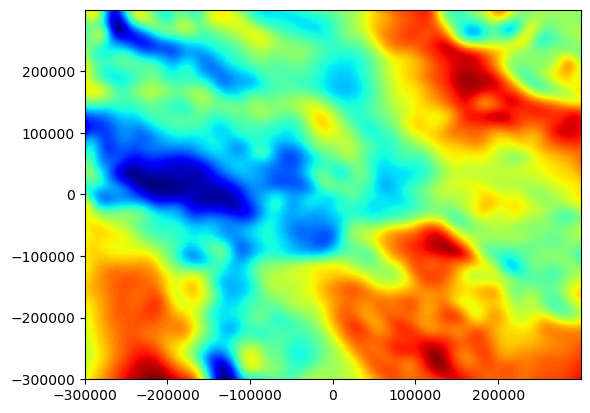

In [6]:
#Resample our grid and make a plot
dx_resample,dy_resample = 500,500 #m
xh,yh = hrr_to_cm1_out['x'],hrr_to_cm1_out['y']
xg,yg = np.arange(xh[0], xh[-1], dx_resample),np.arange(yh[0], yh[-1], dy_resample)
var2 = np.zeros((xg.size,yg.size))*np.nan

var = hrr_to_cm1_out['u'][0]
f = interps.interp2d(hrr_to_cm1_out['x'],hrr_to_cm1_out['y'],var,kind='cubic')
var2 = f(xg, yg).T

XG, YG = np.meshgrid(xg, yg)
plt.pcolormesh(XG, YG,var2.T,cmap='jet')
plt.show()
plt.close()


In [5]:
#Visuals for the CM1 out file
from cartopy.io import shapereader as shpreader
import cartopy.feature as cfeature
from metpy.plots import USCOUNTIES, USSTATES

from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt

for t in range(time.size):
    # ==== USER SETTINGS ====
    NC_PATH = "../cm1/cm1out.nc"     # path to your CM1 output
    SHAPE_PATH = "/Users/tylerpardun/Downloads/tl_2020_40_cousub/tl_2020_40_cousub.shp"  # <- update me
    
    LAT0    = clat           # <-- set your domain center latitude (deg)
    LON0    = clon          # <-- set your domain center longitude (deg)
    LEVEL_K = 0               # lowest vertical level index to plot
    TIME_T  = t               # time index to plot
    # =======================
    
    # --- helpers ---
    EPS   = 0.622          # epsilon = Rd/Rv
    P0    = 100000.0       # Pa
    CP    = 1004.0         # J/kg/K (not used here, kept for reference)
    
    def dewpoint_from_qv_p(qv, p):
        """
        qv: mixing ratio (kg/kg)
        p : pressure (Pa)
        returns dewpoint in degC (same shape as qv)
        Formula: r = qv; e = r * p / (r + EPS)
                 Then Bolton (1980)-style Magnus, e in hPa.
        """
        e_pa  = (qv * p) / (qv + EPS)         # Pa
        e_hpa = e_pa * 0.01                   # hPa
        # Guard tiny/negative values
        e_hpa = np.clip(e_hpa, 1e-6, None)
        ln_arg = np.log(e_hpa / 6.112)
        Td_C = (243.5 * ln_arg) / (17.67 - ln_arg)
        return Td_C
    
    # --- read data ---
    with Dataset(NC_PATH, "r") as nc:
        # Coordinates (xh, yh in km; zh in km, usually)
        xh = nc.variables["xh"][:]            # shape (nx,)
        yh = nc.variables["yh"][:]            # shape (ny,)
        zh = nc.variables["zh"][:]            # shape (nz,)
    
        # 3D fields (assume shape (time, z, y, x) or (z,y,x) depending on build)
        # CM1 "analysis" files are often (z, y, x). If time dim exists, pick TIME_T.
        def read3(name):
            v = nc.variables[name]
            if v.ndim == 4:
                return v[TIME_T, LEVEL_K, :, :]    # (y,x) slice at desired level
            elif v.ndim == 3:
                return v[LEVEL_K, :, :]            # (y,x)
            else:
                raise ValueError(f"{name} has unexpected shape {v.shape}")
    
        def read3_full(name):
            v = nc.variables[name]
            if v.ndim == 4:
                return v[TIME_T, :, :, :]          # (z,y,x)
            elif v.ndim == 3:
                return v[:, :, :]                  # (z,y,x)
            else:
                raise ValueError(f"{name} has unexpected shape {v.shape}")
    
        # Needed variables
        th  = read3_full("th")   # potential temperature [K], (z,y,x)
        pi  = read3_full("pi")   # Exner function [-], (z,y,x)
        qv  = read3_full("qv")   # mixing ratio [kg/kg], (z,y,x)
        prs = read3_full("prs")  # pressure [Pa], (z,y,x)
        u   = read3_full("uinterp")  # wind u [m/s], (z,y,x)
        v   = read3_full("vinterp")  # wind v [m/s], (z,y,x)
    
    # Slice the chosen level
    T   = th[LEVEL_K, :, :] * pi[LEVEL_K, :, :]  # temperature [K]
    QV  = qv[LEVEL_K, :, :]
    P   = prs[LEVEL_K, :, :]
    U   = u[LEVEL_K, :, :]
    V   = v[LEVEL_K, :, :]
    
    # Compute dewpoint (°C)
    TdC = dewpoint_from_qv_p(QV, P)
    
    # Build 2D grids of xh,yh (km) -> lon/lat
    # Convert km offset to degrees: dlat ≈ km / 111, dlon ≈ km / (111 * cos(lat0))
    XKM, YKM = np.meshgrid(xh, yh)  # (ny,nx)
    deg_per_km_lat = 1.0 / 111.0
    deg_per_km_lon = 1.0 / (111.0 * np.cos(np.deg2rad(LAT0)))
    
    LON = LON0 + XKM * deg_per_km_lon
    LAT = LAT0 + YKM * deg_per_km_lat
    
    # --- Plot with Cartopy ---
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature

    proj   = ccrs.PlateCarree()
    fig = plt.figure(figsize=(10, 8))
    ax  = plt.axes(projection=proj)

    # background features
    ax.set_extent([LON.min(), LON.max(), LAT.min(), LAT.max()], crs=proj)
    #ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.6)
    #ax.add_feature(cfeature.BORDERS.with_scale("50m"),  linewidth=0.4)
    #ax.add_feature(cfeature.STATES.with_scale("50m"),   linewidth=0.4)

    #reader = shpreader.Reader(SHAPE_PATH)
    #geoms = list(reader.geometries())
    
    # outline only
    #ax.add_geometries(geoms,crs=ccrs.PlateCarree(),   # data are lon/latfacecolor='none',edgecolor='black',linewidth=1.2,zorder=10)
    ax.add_feature(USCOUNTIES.with_scale('20m'), facecolor='none', edgecolor='k',linewidth=1, zorder=6)
    ax.add_feature(USSTATES.with_scale('20m'), facecolor='none', edgecolor='red',linewidth=1, zorder=6)

    # Filled dewpoint
    cf = ax.contourf(LON, LAT, TdC, levels=np.linspace(10, 20, 100), transform=proj,cmap='jet')
    cbar = plt.colorbar(cf, ax=ax, shrink=0.82, pad=0.02, label="Dewpoint (°C)")

    # Temperature contours (K → optionally plot in °C)
    Tc = T - 273.15
    cs = ax.contour(LON, LAT, Tc, levels=np.arange(-20, 45, 2), colors='k', linewidths=0.8, alpha=0.6, transform=proj)
    ax.clabel(cs, fmt="%.0f°C", inline=True, fontsize=8)

    # Wind barbs — thin out for readability
    skip = (slice(None, None, 12), slice(None, None, 12))
    ax.barbs(LON[skip], LAT[skip], U[skip], V[skip], transform=proj, length=5)

    ax.set_title(f"CM1 Dewpoint (filled), Temp (contours), Wind Barbs\nLevel k={LEVEL_K}, Time index={TIME_T}\nCenter: {LAT0:.3f}°, {LON0:.3f}°")
    plt.tight_layout()
    #plt.savefig('/Users/tylerpardun/Desktop/CM1_dew_{}.png'.format(t),dpi=300,bbox_inches='tight')
    plt.show()
    plt.close()
    break


NameError: name 'time' is not defined